# Chargebacks data Analysis Q4 2017

In [1]:
import sqlite3
import pandas as pd  # <== data processing
import numpy as np  # <== linear algebra
import matplotlib as plt  # data viz
import seaborn as sns  # data viz
%matplotlib inline

## Data wrangling

In [ ]:
# convert each xlsx tab into csv separate files

# visa_xlsx = pd.read_excel('../input/Processing Report.xlsx', 'Visa', index_col=None)  # read data
# visa_xlsx.to_csv('../input/visa.csv', encoding='utf-8', index=False)  # save data

# mastercard_xlsx = pd.read_excel('../input/Processing Report.xlsx', 'Mastercard', index_col=None)
# mastercard_xlsx.to_csv('../input/mastercard.csv', encoding='utf-8', index=False)

In [ ]:
# create dataframes

# df_visa = pd.read_csv('../input/visa.csv')
# df_mastercard = pd.read_csv('../input/mastercard.csv')

In [2]:
# aggregate all data & create bin and last_4 columns

data_concat = pd.concat(pd.read_excel('../input/Processing Report.xlsx', sheet_name=None), ignore_index=True) # aggregate visa & mastercard sheets
# data_concat[['bin', 'last_4']] = data_concat['Masked CCN'].str.replace('\W+','-', 1).str.split('-', expand=True)  # add columns
data_concat[['bin_last_4']] = data_concat['Masked CCN'].str.replace('\W+','', 1)  # oczyść dane w kolumnie Masked CNN, usuń gwiazdki
# data_concat.to_csv('../input/all_data.csv', encoding='utf-8', index=False)
data_concat.to_csv('../input/all_data.csv', encoding='utf-8', index=False)  # utwórz all_data.csv
# df_all = pd.read_csv('../input/all_data.csv')

In [3]:
all_chargebacks = pd.read_csv('../input/all_data.csv') 

In [ ]:
# df_all[['bin', 'last_4']] = df_all['Masked CCN'].str.replace('\W+','-', 1).str.split('-', expand=True)

In [ ]:
# df_all[['bin_last_4']] = df_all['Masked CCN'].str.replace('\W+','', 1)

In [4]:
# database connection
db = sqlite3.connect('../input/db.sqlite')

![db](../images/main_schema.png)DB schema

****************************************************************************************



#### Report Chargeback Data

In [5]:
all_chargebacks.sample(3)

,Transaction Datetime,Currnecy,Amount,Masked CCN,Card Brans,ARN,bin_last_4
262,2017-11-21 15:46:18,EUR,240,529188******5922,mastercard,NaN,5291885922
208,2017-10-11 19:02:43,USD,120,551029******8293,mastercard,NaN,5510298293
42,2017-10-19 11:06:01,EUR,270,424587******4549,visa,2DD77FW7-1508403961-100375982-VPYU417X5N,4245874549


In [6]:
all_chargebacks['bin_last_4'].nunique()

205

In [7]:
all_chargebacks.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318 entries, 0 to 317
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Transaction Datetime  318 non-null    object
 1   Currnecy              318 non-null    object
 2   Amount                318 non-null    int64 
 3   Masked CCN            318 non-null    object
 4   Card Brans            318 non-null    object
 5   ARN                   193 non-null    object
 6   bin_last_4            318 non-null    int64 
dtypes: int64(2), object(5)
memory usage: 17.5+ KB


In [8]:
cards_indx_q = pd.read_sql_query('''select 
                                    cast(bin || last_4 as int) as bin_last_4,
                                    cast(bin || last_4 as int) as bin_last,
                                    id from cards''', db)
cards_indx_q.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9997 entries, 0 to 9996
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   bin_last_4  9997 non-null   int64
 1   bin_last    9997 non-null   int64
 2   id          9997 non-null   int64
dtypes: int64(3)
memory usage: 234.4 KB


#### Append id numbers to chargebx dataframe

In [9]:
# append ids from cards_indx to data_all
chargebx = pd.merge(all_chargebacks,
                     cards_indx_q,
                     on='bin_last_4',
                     how='inner')
chargebx.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322 entries, 0 to 321
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Transaction Datetime  322 non-null    object
 1   Currnecy              322 non-null    object
 2   Amount                322 non-null    int64 
 3   Masked CCN            322 non-null    object
 4   Card Brans            322 non-null    object
 5   ARN                   194 non-null    object
 6   bin_last_4            322 non-null    int64 
 7   bin_last              322 non-null    int64 
 8   id                    322 non-null    int64 
dtypes: int64(4), object(5)
memory usage: 25.2+ KB


In [10]:
chargebx = chargebx.rename(columns=
                           {'id':'card_id',
                            'Transaction Datetime': 'created_at'})
chargebx['chargeback'] = 1
chargebx['chargeback'].astype(int)
chargebx.drop(['bin_last'], axis=1)

,created_at,Currnecy,Amount,Masked CCN,Card Brans,ARN,bin_last_4,card_id,chargeback
0,2017-10-02 01:19:58,USD,70,483316******3047,visa,2DD77FW7-1506899998-100375982-D4QGK72CC0,4833163047,1503771540,1
1,2017-12-08 13:36:50,USD,140,483316******3047,visa,2DD77FW7-1512736610-100375145-SD7LET6DQY,4833163047,1503771540,1
2,2017-10-02 08:21:16,EUR,100,403905******6257,visa,2DD77FW7-1506925276-100375856-3CLLAK8JZ0,4039056257,1497252601,1
3,2017-10-02 16:57:29,USD,50,485340******8306,visa,2DD77FW7-1506956249-100632165-A35L6E461Z,4853408306,1488640432,1
4,2017-10-03 06:14:16,EUR,240,494172******3012,visa,2DD77FW7-1507004056-100632165-HZCR6EGFSX,4941723012,1495394992,1
...,...,...,...,...,...,...,...,...,...
317,2017-12-29 04:29:43,USD,130,510277******9790,mastercard,NaN,5102779790,1505590236,1
318,2017-12-29 12:25:53,USD,90,533621******5038,mastercard,NaN,5336215038,1501764998,1
319,2017-12-29 20:33:23,EUR,170,533248******4967,mastercard,NaN,5332484967,1505941882,1
320,2017-12-29 21:45:11,USD,260,543924******5461,mastercard,NaN,5439245461,1504064117,1


In [11]:
# chargbacks with ids
chargebx.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322 entries, 0 to 321
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   created_at  322 non-null    object
 1   Currnecy    322 non-null    object
 2   Amount      322 non-null    int64 
 3   Masked CCN  322 non-null    object
 4   Card Brans  322 non-null    object
 5   ARN         194 non-null    object
 6   bin_last_4  322 non-null    int64 
 7   bin_last    322 non-null    int64 
 8   card_id     322 non-null    int64 
 9   chargeback  322 non-null    int64 
dtypes: int64(5), object(5)
memory usage: 27.7+ KB


#### Get country info from db

In [12]:
country = pd.read_sql_query('''
                            select card_id,
                            ip_country
                            from customers;
                            ''', db)
country.head()

,card_id,ip_country
0,1492866731,CZ
1,1508145460,VE
2,1488642434,MX
3,1498663410,HR
4,1502538662,FR


In [13]:
# Append countries values to the charbx dataset
chargebacks = pd.merge(chargebx, country, on='card_id', how='inner')
chargebacks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322 entries, 0 to 321
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   created_at  322 non-null    object
 1   Currnecy    322 non-null    object
 2   Amount      322 non-null    int64 
 3   Masked CCN  322 non-null    object
 4   Card Brans  322 non-null    object
 5   ARN         194 non-null    object
 6   bin_last_4  322 non-null    int64 
 7   bin_last    322 non-null    int64 
 8   card_id     322 non-null    int64 
 9   chargeback  322 non-null    int64 
 10  ip_country  322 non-null    object
dtypes: int64(5), object(6)
memory usage: 30.2+ KB


In [14]:
# Append countries values to the chargebx dataset
chargebacks = pd.merge(chargebx, country, on='card_id', how='inner')
chargebacks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322 entries, 0 to 321
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   created_at  322 non-null    object
 1   Currnecy    322 non-null    object
 2   Amount      322 non-null    int64 
 3   Masked CCN  322 non-null    object
 4   Card Brans  322 non-null    object
 5   ARN         194 non-null    object
 6   bin_last_4  322 non-null    int64 
 7   bin_last    322 non-null    int64 
 8   card_id     322 non-null    int64 
 9   chargeback  322 non-null    int64 
 10  ip_country  322 non-null    object
dtypes: int64(5), object(6)
memory usage: 30.2+ KB


*****************************************************************************************

#### Get & review transaction db data

In [68]:
# get all transactons from database, deduplicate
trans_q = pd.read_sql_query('select * from transactions', db)
trans_q

,id,created_at,succes,amount,currency,acq_tid,card_id,cb
0,1507276519,2017-10-06 09:55:19,1,1300,USD,2DD77FW7-1507276519-100375145-6UDOLBNLXD,1492866731,0
1,1512262637,2017-12-03 01:57:17,1,400,USD,2DD77FW7-1512262637-100375145-5JEOCILQ7T,1492866731,0
2,1509745157,2017-11-03 22:39:17,0,3100,USD,2DD77FW7-1509745157-100375982-BTT12YQNUZ,1492866731,0
3,1507921724,2017-10-13 21:08:44,1,1300,EUR,2DD77FW7-1507921724-100375856-TRGTYMVYHO,1508145460,0
4,1514277559,2017-12-26 09:39:19,0,900,USD,2DD77FW7-1514277559-100632165-2IGY9D935C,1508145460,0
...,...,...,...,...,...,...,...,...
34882,1509344162,2017-10-30 07:16:02,0,1100,EUR,2DD77FW7-1509344162-100375982-MLL5EI46VB,1486963470,0
34883,1508247730,2017-10-17 15:42:10,1,500,USD,2DD77FW7-1508247730-100375982-EC6TWNFBKG,1486963470,0
34884,1511906262,2017-11-28 22:57:42,1,2000,EUR,2DD77FW7-1511906262-100632165-L910QUP8H3,1486963470,0
34885,1507232561,2017-10-05 21:42:41,1,1900,USD,2DD77FW7-1507232561-100375856-XDYEYEG4RD,1486963470,0


In [69]:
# get dataset shape
trans_q.info()
trans_q.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34887 entries, 0 to 34886
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          34887 non-null  int64 
 1   created_at  34887 non-null  object
 2   succes      34887 non-null  int64 
 3   amount      34887 non-null  int64 
 4   currency    34887 non-null  object
 5   acq_tid     34887 non-null  object
 6   card_id     34887 non-null  int64 
 7   cb          34887 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 2.1+ MB


(34887, 8)

#### Understand cb cell

In [17]:
trans_q.cb.nunique()

1

In [18]:
trans_q.cb.value_counts()

0    34887
Name: cb, dtype: int64

#### Understand success cell

In [19]:
# success ratio
trans_q.succes.value_counts(dropna=False)
trans_q.succes.value_counts(normalize=True)

1    0.630349
0    0.369651
Name: succes, dtype: float64

In [20]:
# extract card ids based on bin & last_4 card data
transax = pd.merge(trans_q, chargebx, on=['created_at', 'card_id'], how='left')
transax.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34887 entries, 0 to 34886
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          34887 non-null  int64  
 1   created_at  34887 non-null  object 
 2   succes      34887 non-null  int64  
 3   amount      34887 non-null  int64  
 4   currency    34887 non-null  object 
 5   acq_tid     34887 non-null  object 
 6   card_id     34887 non-null  int64  
 7   cb          34887 non-null  int64  
 8   Currnecy    318 non-null    object 
 9   Amount      318 non-null    float64
 10  Masked CCN  318 non-null    object 
 11  Card Brans  318 non-null    object 
 12  ARN         193 non-null    object 
 13  bin_last_4  318 non-null    float64
 14  bin_last    318 non-null    float64
 15  chargeback  318 non-null    float64
dtypes: float64(4), int64(5), object(7)
memory usage: 4.5+ MB


In [21]:
transax.loc[transax['chargeback'] == 1]
transax.sample(3)

,id,created_at,succes,amount,currency,acq_tid,card_id,cb,Currnecy,Amount,Masked CCN,Card Brans,ARN,bin_last_4,bin_last,chargeback
13601,1510565911,2017-11-13 10:38:31,0,400,EUR,2DD77FW7-1510565911-100632165-3NPBMSKZCF,1511232263,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16662,1507920281,2017-10-13 20:44:41,1,700,USD,2DD77FW7-1507920281-100375856-KAY7TEU4UK,1501135827,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11638,1512211079,2017-12-02 11:37:59,1,1800,EUR,2DD77FW7-1512211079-100375856-PPN7R0OTVJ,1494595410,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# temp = pr.read_sql_query('create temporaty table temp_transactions', db)

In [22]:
# dataset clean-up [data types, columns names, delete]
# transax = pd.merge(trans_q, country, on='card_id', how='inner')
transax = pd.merge(trans_q, chargebx, on=['created_at', 'card_id'], how='left')
transax = transax.fillna('')
transax['chargeback'] = transax['chargeback'].replace(r'^\s*$', 0, regex=True).astype('Int64')
transax['Amount'] = transax['Amount'].replace(r'^\s*$', 0, regex=True).astype('Int64')

transax.rename(columns=
               {
                   'id': 't_id',
                   'amount': 't_amount',
                   'currency': 't_curr',
                   'Currnecy': 'cback_curr',
                   'Amount': 'cback_amnt',
                   'Card Brans': 'c_brand'
               }, inplace=True
              )
transax.drop(['cb', 'Masked CCN', 'bin_last_4'], axis=1, inplace=True)
transax['cback_amnt'] = transax['cback_amnt']
# dataset check
transax = pd.merge(transax, country, on='card_id', how='inner')
transax.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34887 entries, 0 to 34886
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   t_id        34887 non-null  int64 
 1   created_at  34887 non-null  object
 2   succes      34887 non-null  int64 
 3   t_amount    34887 non-null  int64 
 4   t_curr      34887 non-null  object
 5   acq_tid     34887 non-null  object
 6   card_id     34887 non-null  int64 
 7   cback_curr  34887 non-null  object
 8   cback_amnt  34887 non-null  Int64 
 9   c_brand     34887 non-null  object
 10  ARN         34887 non-null  object
 11  bin_last    34887 non-null  object
 12  chargeback  34887 non-null  Int64 
 13  ip_country  34887 non-null  object
dtypes: Int64(2), int64(4), object(8)
memory usage: 4.1+ MB


In [86]:
chback_cards = pd.merge(trans_q, chargebx, on=['card_id'], how='inner')

chback_cards.rename(columns=
               {
                   'created_at_x': 't_created_at',
                   'created_at_y': 'created_at'

               }, inplace=True)
chback_cards.drop(['cb', 'Masked CCN', 'bin_last_4', 'bin_last', 'chargeback', 'ARN'], axis=1, inplace=True)
chback_cards.info()
chback_cards.to_csv('../output/chback_cards.csv')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1528 entries, 0 to 1527
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1528 non-null   int64 
 1   t_created_at  1528 non-null   object
 2   succes        1528 non-null   int64 
 3   amount        1528 non-null   int64 
 4   currency      1528 non-null   object
 5   acq_tid       1528 non-null   object
 6   card_id       1528 non-null   int64 
 7   created_at    1528 non-null   object
 8   Currnecy      1528 non-null   object
 9   Amount        1528 non-null   int64 
 10  Card Brans    1528 non-null   object
dtypes: int64(5), object(6)
memory usage: 143.2+ KB


********************************************************************************

### Data Analysis 

Chargebacks counts

In [23]:
transax.groupby(['chargeback']).size()
# transax.groupby(['chargeback', 'succes'])['succes'].value_counts()
# transax.groupby(['succes']).size()
# transax.chargeback.value_counts(dropna=True)

chargeback
0    34569
1      318
dtype: int64

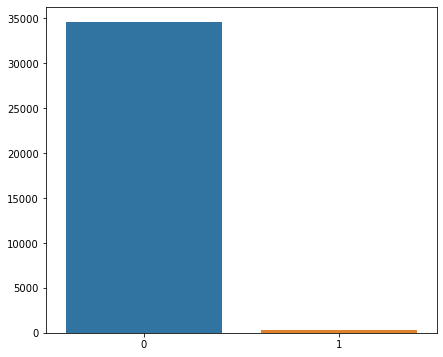

In [24]:
val = transax.chargeback.value_counts()
# sns.set(font_scale=1.1)
transax.chargeback.value_counts(dropna=True).plot(kind='bar', figsize=(7, 6), rot=0);
sns.barplot(x=val.index, y=val.values);

% Chargeback rate for Q4

In [25]:
transax.chargeback.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

0    99.1%
1     0.9%
Name: chargeback, dtype: object

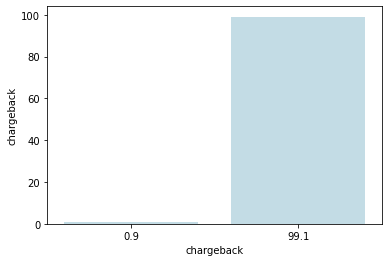

In [26]:
# Percentage distribution
prcent = transax.chargeback.value_counts(normalize=True).mul(100).round(1)
sns.barplot(x=prcent, y=prcent, color='lightblue', alpha=0.8);

#### Chargebacks data from transax dataframe

In [27]:
# create updated chargeback data
charbx = transax.loc[transax['chargeback']==1]
# charbx['cback_amnt'] = charbx['cback_amnt'].astype('int64')
charbx.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318 entries, 100 to 34701
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   t_id        318 non-null    int64 
 1   created_at  318 non-null    object
 2   succes      318 non-null    int64 
 3   t_amount    318 non-null    int64 
 4   t_curr      318 non-null    object
 5   acq_tid     318 non-null    object
 6   card_id     318 non-null    int64 
 7   cback_curr  318 non-null    object
 8   cback_amnt  318 non-null    Int64 
 9   c_brand     318 non-null    object
 10  ARN         318 non-null    object
 11  bin_last    318 non-null    object
 12  chargeback  318 non-null    Int64 
 13  ip_country  318 non-null    object
dtypes: Int64(2), int64(4), object(8)
memory usage: 37.9+ KB


#### Chargebacks Cards analysis

In [28]:
# Cards distribution in chargebacks.
charbx.c_brand.value_counts()

visa          193
mastercard    125
Name: c_brand, dtype: int64

In [29]:
# %
charbx.c_brand.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

visa          60.7%
mastercard    39.3%
Name: c_brand, dtype: object

#### Customers overview data

In [32]:
# get customer info form db, create dataframe
custmr_q = pd.read_sql_query('''select * from customers;''', db)

In [33]:
# dataframe info
customers = custmr_q.drop(['created_at'], axis=1)
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9997 entries, 0 to 9996
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          9997 non-null   int64 
 1   card_id     9997 non-null   int64 
 2   name        9997 non-null   object
 3   email       9997 non-null   object
 4   ip_addr     9997 non-null   object
 5   ip_country  9997 non-null   object
dtypes: int64(2), object(4)
memory usage: 468.7+ KB


In [34]:
customers.sample(3)

,id,card_id,name,email,ip_addr,ip_country
8597,1508238108,1508238107,Madge Abbott,madge_abbott@gmail.com,208.31.49.20,TZ
1655,1491516582,1491516581,Deanne Seymour,deanne_seym@gmail.com,173.48.252.181,IL
5478,1509458194,1509458193,Natalia Mora,mora-natalia7948@aol.com,65.182.237.55,NA


#### All Unique customers

In [35]:
customers['id'].nunique()

9997

#### Customers per country

In [36]:
all_c = customers.groupby('ip_country')['id'].count()

#### Countries with highest customer counts

In [37]:
top_10 = all_c.nlargest(20)
top_10

ip_country
SE    239
PL    233
HU    224
BS    223
IE    220
ES    219
CA    218
NO    218
PY    218
MT    217
US    217
VE    214
DZ    213
NL    212
KW    210
MX    210
JP    208
KR    208
PA    208
KG    206
Name: id, dtype: int64

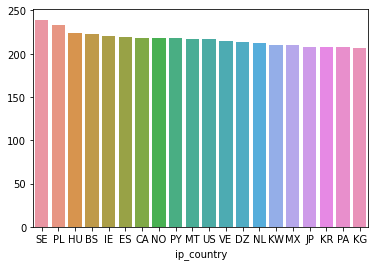

In [38]:
sns.barplot(x=top_10.index, y=top_10.values);

**************************************

### Chargebacks Analaysis Q4 2017

#### Unique countries (all transactions)

In [39]:
transax['ip_country'].nunique()

49

#### TOP 20 countries (transactions)

In [40]:
t_cntry = transax['ip_country']
tc = t_cntry.value_counts()[:20]
tc

PL    854
SE    815
KW    781
HU    780
BS    776
US    776
MX    769
PY    765
CY    762
ES    760
MT    759
AR    751
CH    751
DZ    749
VE    748
NL    747
KG    746
IE    746
CA    745
IT    729
Name: ip_country, dtype: int64

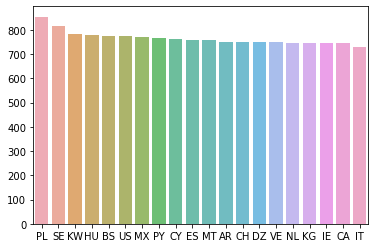

In [41]:
sns.barplot(x=tc.index, y=tc.values, alpha=0.8);

In [42]:
tc_prc = t_cntry.value_counts(normalize=True).mul(100).round(1)[:10]
tc_prc

PL    2.4
SE    2.3
KW    2.2
HU    2.2
BS    2.2
US    2.2
MX    2.2
PY    2.2
CY    2.2
ES    2.2
Name: ip_country, dtype: float64

#### Unique countries (chargebacks)

In [43]:
charbx.ip_country.nunique()

49

#### Chargebacks per country

In [44]:
# pd.options.display.max_rows = 999

country = charbx.ip_country.value_counts()
country = country[:10]
country

PA    47
RU    33
TR    29
TH    28
NO    11
JP     8
PL     7
SA     7
NL     7
PT     7
Name: ip_country, dtype: int64

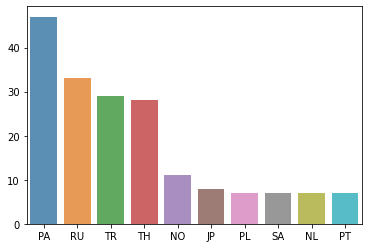

In [45]:
sns.barplot(x=country.index, y=country.values, alpha=0.8);

#### Chargeback % rate per country

In [46]:
country_prc = charbx.ip_country.value_counts(normalize=True).mul(100).round(1)
country_prc[:10].astype(str) + '%'

PA    14.8%
RU    10.4%
TR     9.1%
TH     8.8%
NO     3.5%
JP     2.5%
PL     2.2%
SA     2.2%
NL     2.2%
PT     2.2%
Name: ip_country, dtype: object

#### Chargebacks per Country Transactions

In [ ]:
t = pd.Series(t_cntry.value_counts(), name='Transaction#')
c = pd.Series(charbx.ip_country.value_counts(), name='Chargeback#')
per_cntry = pd.concat([t, c], axis=1)
per_cntry.sort_values(['Chargeback#'], ascending=[False])[:10]

# percentage = per_cntry['Transaction#'].div(per_cntry['Chargeback#'].transform(lambda x: x /x.sum().mul(100)))
per_cntry['Percentage of CHarg'] = \
np.where(per_cntry['Transaction#'] < 1, per_cntry['Transaction#'], 
         (per_cntry['Chargeback#']/per_cntry['Transaction#']).mul(100).round(2).astype(str)+'%')

per_cntry.sort_values(['Percentage of CHarg'], ascending=False)[:10]

****************************************************

### Chargebacks Cards Analysis

#### Top Cards

In [47]:
chargebacks_per_crd = charbx.groupby('card_id').size()
chargebacks_per_crd.sort_values(ascending=False)[:5]

card_id
1486952657    6
1494920868    6
1514084474    6
1502600050    5
1500719479    5
dtype: int64

#### # of Cards

In [48]:
chargebacks_per_crd.count()

205

#### Top Cards Countries

In [49]:
ch = chargebacks_per_crd.to_frame(name='Chargeback#_card')

with_c = charbx[['card_id', 'ip_country']] 
with_c

with_country = ch.merge(with_c, on='card_id', how='right')
card_per_country = with_country.groupby(['card_id','ip_country']).count()
card_per_country.sort_values('Chargeback#_card', ascending=False)[:10]

,,Chargeback#_card
card_id,ip_country,
1494920868,TR,6
1486952657,PA,6
1514084474,RU,6
1502600050,NO,5
1500719479,RU,5
1502948866,TH,4
1513771868,PA,4
1496395117,PA,4
1505286417,RU,4


#### Cards with more than 2 chargebacks in Q4 2017

In [50]:
chargebacks_per_crd[chargebacks_per_crd > 2].sum()

128

In [51]:
# Cards distribution in chargebacks.
charbx.c_brand.value_counts()

visa          193
mastercard    125
Name: c_brand, dtype: int64

In [52]:
charbx.c_brand.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

visa          60.7%
mastercard    39.3%
Name: c_brand, dtype: object

In [53]:
cards = pd.merge(trans_q, chargebx, on=['card_id'], how='left')
cards = cards.fillna('')
cards['chargeback'] = cards['chargeback'].replace(r'^\s*$', 0, regex=True).astype('Int64')
cards['Amount'] = cards['Amount'].replace(r'^\s*$', 0, regex=True).astype('Int64')

cards.rename(columns=
               {
                   'id': 't_id',
                   'created_at_x': 't_created_at',
                   'amount': 't_amount',
                   'currency': 't_curr',
                   'created_at_y': 'cback_created_at',
                   'Currnecy': 'cback_curr',
                   'Amount': 'cback_amnt',
                   'Card Brans': 'card_brand'
               }, inplace=True
              )
cards.drop(['cb', 'Masked CCN', 'bin_last_4'], axis=1, inplace=True)
cards['cback_amnt'] = cards['cback_amnt']
# # dataset check
# cards = pd.merge(cards, country, on='card_id', how='inner')
cards.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35457 entries, 0 to 35456
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   t_id              35457 non-null  int64 
 1   t_created_at      35457 non-null  object
 2   succes            35457 non-null  int64 
 3   t_amount          35457 non-null  int64 
 4   t_curr            35457 non-null  object
 5   acq_tid           35457 non-null  object
 6   card_id           35457 non-null  int64 
 7   cback_created_at  35457 non-null  object
 8   cback_curr        35457 non-null  object
 9   cback_amnt        35457 non-null  Int64 
 10  card_brand        35457 non-null  object
 11  ARN               35457 non-null  object
 12  bin_last          35457 non-null  object
 13  chargeback        35457 non-null  Int64 
dtypes: Int64(2), int64(4), object(8)
memory usage: 4.1+ MB


#### All transactions # with cards used at least once as chargeback

In [54]:
# pd.options.display.max_rows = 
c_both = pd.merge(trans_q, charbx, on=['card_id'], how='inner')
cards['chargeback'].value_counts()

0    33929
1     1528
Name: chargeback, dtype: Int64

#### %

In [55]:
cards['chargeback'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

0    95.7%
1     4.3%
Name: chargeback, dtype: object

### Analysis Summary


- **Chargebacks data for Q4 2017 for unknown Merchant.**
- Total unique Customers: **9997** (100%).
- Total unique Countries: **49**.
- Top Country Transaction-wise: **Poland**
- Top Country Chargeback-wise: **Panama**
- Chargebacks Countries: **49**.
- Total transactions: **34 887** (100%).
- No-Chargebacks: **34 569** (99.1%).
- Chargebacks transactions: **318** (0.9% of all Transactions).
- Chargebacks transactions *VISA* : **193** (60.7% of all Chargebacks).
- Chargebacks transactions *MasterCard* : **125** (39.3% of all Chargebacks).
- **Chargeback Transactions don't exceed 1.0% of all Transactions**
- The same cards are used in both kind of transactions.
- All transactions # with cards used at least once as chargeback: **1528** (**4.3%** of all Transactions).
- There are **210** unique cards used to chargeback that Merchant.
- Top # of Chargeback per a Card: **6** (Turkey, Panama, Russia)
- All unique Cards with Chargeback # more than 2: **128**

------------------------------------------------------

**************************************************
**Author:** Marcel Łagoda
*************************************************